In [2]:
%load_ext autoreload
%autoreload 2

import torch
import torch.nn.functional as F
from PIL import Image
import numpy as np
import mediapy
import os
import sys
from pathlib import Path
sys.path.append(os.getcwd() + "/submodules/OpenLRM")

from openlrm.datasets.cam_utils import create_intrinsics, build_camera_standard
import viser.transforms as tf


from p3d.models.openlrm import OpenLRM

/home/riley/miniforge3/envs/p3d/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
name = "objaverse_00"

ref_dir = Path(f"data/{name}/renders")
test_dir = Path(f"data/{name}/rand_renders")

renders = list(ref_dir.glob("*.png"))
renders.sort()
tests = list(test_dir.glob("*.png"))
tests.sort()

""

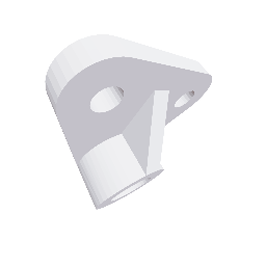

In [49]:
def load_image(image_path, source_size=266):
    image = torch.from_numpy(np.array(Image.open(image_path)))
    image = image.permute(2, 0, 1).unsqueeze(0) / 255.0
    if image.shape[1] == 4:  # RGBA
        image = image[:, :3, ...] * image[:, 3:, ...] + (1 - image[:, 3:, ...])

    height, width = image.shape[2:]
    height_pad = max(0, (width-height) //2)
    width_pad = max(0, (height-width) //2)

    image = F.pad(image, (width_pad, width_pad, height_pad, height_pad), "constant", value=1)
    image = torch.nn.functional.interpolate(image, size=(source_size, source_size), mode='bicubic', align_corners=True)
    image = torch.clamp(image, 0, 1)
    return image

render_path = renders[1005]
render_image = load_image(render_path)
mediapy.show_image(render_image[0].permute(1, 2, 0))

In [50]:
olrm = OpenLRM(device="cuda:0")
olrm.process_image(render_image)

Accelerated


In [94]:
theta_0, phi_0, psi_0 = str(render_path).split("/")[-1].split("_")[-3:]
theta_0, phi_0, psi_0 = float(theta_0), float(phi_0), float(psi_0[:-4])

theta_0 = theta_0 / 180 * np.pi
phi_0 = phi_0 / 180 * np.pi
psi_0 = psi_0 / 180 * np.pi

theta_0, phi_0, psi_0

(0.8726646259971648, 0.48328166987722987, 5.585053606381854)

In [95]:
initial_rotation = tf.SO3.multiply(tf.SO3.from_z_radians(psi_0), tf.SO3.multiply(tf.SO3.from_y_radians(theta_0), tf.SO3.from_z_radians(phi_0))).as_matrix()

x, y, z = np.sin(theta_0) * np.cos(phi_0), np.sin(theta_0) * np.sin(phi_0), np.cos(theta_0)
initial_position = np.array([x, y, z])

initial_position

array([0.67831301, 0.35597128, 0.64278761])

In [105]:
theta_, phi_, psi_ = -theta_0, -phi_0, -psi_0

theta = theta_ / 180 * np.pi
phi = phi_ / 180 * np.pi
psi = psi_ / 180 * np.pi

x, y, z = np.sin(theta) * np.cos(phi), np.sin(theta) * np.sin(phi), np.cos(theta)
position = np.array([x, y, z])

roll = tf.SO3.from_z_radians(psi)
dir  = tf.SO3.multiply(tf.SO3.from_z_radians(phi), tf.SO3.from_y_radians(theta))
rotation = tf.SO3.multiply(dir, roll).as_matrix()

correction = tf.SO3.from_x_radians(np.pi / 2).as_matrix()

print(position)

rotation = torch.from_numpy(correction @ rotation)
position = torch.from_numpy(correction @ position).unsqueeze(1)

extrinsics = torch.cat([rotation, position], dim=1).unsqueeze(0).float()

intrinsics = create_intrinsics(0.75, c=0.5).unsqueeze(0)
render_cameras = build_camera_standard(extrinsics, intrinsics).unsqueeze(0)

[-1.52297403e-02  1.28463719e-04  9.99884013e-01]


""

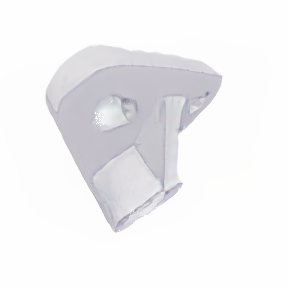

In [106]:
image = olrm.generate_image(render_cameras)
mediapy.show_image(image[0])